# Classificando músicas utilizando KNN

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('musicas_features.xlsx', usecols = "B:T")
df = df[(df['id'].notnull()) & (df['Ano'] != 2020)]
df = df.drop_duplicates(subset=['id'], keep='last')
df['Ano'] = df['Ano'].astype(int)
df.head()

,Posicao,Musica,Artista,Ano,id,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1.0,Balancê,Gal Costa,1980,2m1G38M0gJuE4aVPh0tmIP,1979-01-08,0.638,0.736,9.0,-10.536,1.0,0.0811,0.0849,0.000000,0.333,0.881,144.823,188667.0,4.0
1,4.0,Momentos,Joanna,1980,5ncQCIFnjpHWRXbuKFG8RP,2002-11-08,0.501,0.296,7.0,-12.018,0.0,0.0292,0.8020,0.006370,0.117,0.305,132.462,235147.0,4.0
2,5.0,Menino do Rio,Baby Consuelo,1980,6tisytwaOaBA4CAZPPdlFP,1978-09-14,0.380,0.548,0.0,-9.260,1.0,0.0333,0.7300,0.000142,0.310,0.395,152.498,263733.0,4.0
3,6.0,Toada (Na Direção do Dia),Boca Livre,1980,2LO6c0rfmBm49Qs9KtQR1W,2007-01-01,0.402,0.506,6.0,-13.094,0.0,0.0409,0.9280,0.000946,0.728,0.446,97.082,233707.0,4.0
4,9.0,Meu Bem Querer,Djavan,1980,5ogHB4oYt1C7kaWJYm5MDG,1999-03-25,0.519,0.457,9.0,-8.450,1.0,0.0326,0.7630,0.000666,0.796,0.264,81.561,254800.0,4.0


## Determinando a década de cada música

In [3]:
def obter_decada(linha):
    ano = str(linha['Ano'])
    if "198" in ano:
        return "1980"
    if "199" in ano:
        return "1999"
    if "200" in ano:
        return "2000"
    if "201" in ano:
        return "2010"
    return "-"

df['Decada'] = df.apply (lambda x: obter_decada(x), axis=1)

##  Dividindo o dataset em base de teste e treino

In [4]:
X = df[['danceability', 'energy', 'key', 'loudness', 'mode', 
        'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
        'valence', 'tempo', 'duration_ms', 'time_signature']]
y = df['Decada']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

## Gerando o melhor valor para n_neighbors

In [6]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
params = {'n_neighbors': np.arange(1, 100)}
knn_gscv = GridSearchCV(knn, params)
knn_gscv.fit(X, y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [7]:
best_k = knn_gscv.best_params_['n_neighbors']
print('Melhor resultado: ', best_k)

Melhor resultado:  45


## Classificador

In [8]:
classifier = KNeighborsClassifier(
    n_neighbors=best_k, 
    p=4, # quantidade de décadas a serem testadas
    metric='euclidean')

In [9]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=45, p=4)

In [10]:
y_pred = classifier.predict(X_test)

In [11]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 29  55  24  12]
 [ 27  64  28  18]
 [ 16  30  61  42]
 [  5  10  21 159]]


In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
print('f1_score: ', f1_score(y_test, y_pred, average='weighted'))

0.50643891565926


In [13]:
print('accuracy_score:', accuracy_score(y_test, y_pred))

0.5207986688851913


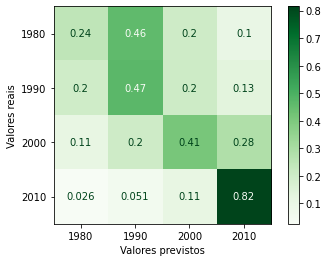

In [14]:
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             display_labels=[1980, 1990, 2000, 2010],
                             cmap=plt.cm.Greens,
                             normalize='true')
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.show()